# Grid search de modelos y MLFlow

In [56]:
# Importación de librerías para los datos y gráficas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os


# Importación de MLFlow
import mlflow
import mlflow.sklearn
import mlflow.tracking
#from mlflow.models import infer_signature

# Importar elementos del modelo
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import learning_curve

import dagshub

In [57]:
# import mlflow
# from mlflow.tracking import MlflowClient
# import os

# # Configurar la URI de seguimiento para DagsHub
# mlflow.set_tracking_uri("https://dagshub.com/empleo-inducido/project-ml.mlflow")

# # Autentificación (si es necesario)
# # os.environ['MLFLOW_TRACKING_USERNAME'] = 'tu-usuario'
# # os.environ['MLFLOW_TRACKING_PASSWORD'] = 'tu-token-de-acceso-personal'

# # Configurar el experimento
# mlflow.set_experiment("Proyecto_Dengue_AAA")

# # Crear un cliente de MLflow
# client = MlflowClient()

# # Suponiendo que tienes un experimento en local con ID "0"
# local_experiment_id = "0"
# runs = client.search_runs(experiment_ids=[local_experiment_id])

# for run_info in runs:
#     try:
#         # Cargar la información del run
#         run_id = run_info.info.run_id
#         local_run = client.get_run(run_id)
        
#         # Crear un nuevo run en DagsHub y loggear la información
#         with mlflow.start_run(run_name=local_run.info.run_name) as new_run:
#             new_run_id = new_run.info.run_id
            
#             # Copiar los parámetros, métricas y artefactos del run local al nuevo run
#             for key, value in local_run.data.params.items():
#                 mlflow.log_param(key, value)
            
#             for key, value in local_run.data.metrics.items():
#                 mlflow.log_metric(key, value)
            
#             # Loggear artefactos
#             artifacts = client.list_artifacts(run_id)
#             for artifact in artifacts:
#                 local_path = client.download_artifacts(run_id, artifact.path)
#                 mlflow.log_artifact(local_path, artifact_path=artifact.path)
            
#             # Optional: Copiar las tags
#             for key, value in local_run.data.tags.items():
#                 mlflow.set_tag(key, value)
    
#     except Exception as e:
#         print(f"Error al transferir el run {run_id}: {e}")


In [58]:
dagshub.init(repo_owner='empleo-inducido', repo_name='project-ml', mlflow=True)

Initialized MLflow to track repo "empleo-inducido/project-ml"

Repository empleo-inducido/project-ml initialized!

In [59]:
mlflow.autolog()

2024/06/02 22:50:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/06/02 22:50:42 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


In [60]:
#!pip install mlflow

In [61]:
# Configuramos la MLflow Tracking URI
track_uri = "https://dagshub.com/empleo-inducido/project-ml.mlflow"
mlflow.set_tracking_uri(track_uri)
# Establece la URI del registro de modelos de MLflow.
mlflow.set_registry_uri("sqlite:////tmp/registry.db")

In [62]:
# Generando el experimento o cargandolo si existe
experiment_name = "Proyecto_Dengue_AAA"
mlflow.set_experiment(experiment_name)

# Cargando la información
client = mlflow.tracking.MlflowClient()
experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

# Validacion
print(f"MLflow Version: {mlflow.__version__}")
print(f"Tracking URI: {mlflow.tracking.get_tracking_uri()}")
print(f"Nombre del experimento: {experiment_name}")
print(f"ID del experimento: {experiment_id}")

MLflow Version: 2.13.0
Tracking URI: https://dagshub.com/empleo-inducido/project-ml.mlflow
Nombre del experimento: Proyecto_Dengue_AAA
ID del experimento: 1


## Cargar datos

In [63]:
# Cargar datos desde el archivo Parquet
train = pd.read_parquet("../data/db/processed_train_data.parquet")

In [64]:
# Cargar datos desde el archivo Parquet
test = pd.read_parquet("../data/db/processed_test_data.parquet")

In [65]:
train.shape

(40063, 24)

In [66]:
test.shape

(10016, 24)

### Balanceo de clases

In [67]:
train['TIPO_PACIENTE'].value_counts()

TIPO_PACIENTE
1    31477
2     8586
Name: count, dtype: int64

In [68]:
# Separar características y etiquetas
X_train = train.drop(columns=['TIPO_PACIENTE'])
y_train = train['TIPO_PACIENTE']

X_test = test.drop(columns=['TIPO_PACIENTE'])
y_test = test['TIPO_PACIENTE']

In [69]:
# from imblearn.over_sampling import RandomOverSampler
# # Crear el objeto RandomOverSampler
# oversample = RandomOverSampler()

# # Aplicar el sobremuestreo a tus datos
# X_resampled, y_resampled = oversample.fit_resample(X_train, y_train)

In [70]:
from imblearn.under_sampling import RandomUnderSampler

# Crear el objeto RandomUnderSampler
undersample = RandomUnderSampler()

# Aplicar el submuestreo a tus datos
X_resampled, y_resampled = undersample.fit_resample(X_train, y_train)


In [71]:
y_resampled.value_counts()

TIPO_PACIENTE
1    8586
2    8586
Name: count, dtype: int64

## Grid de modelos

In [72]:
models = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'max_iter': [100, 200, 300],
            'multi_class': ['ovr', 'multinomial'],
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            #'C': [0.1, 1],
            'kernel': ['linear']#, 'rbf']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [None, 10, 20, 30]
        }
    },
    'GradientBoostingClassifier': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
    },
    'KNeighborsClassifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9]
        }
    }
}


## Logistic Regression

/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/site-packages/mlflow/utils/autologging_utils/safety.py", line 576, in safe_patch_function
    patch_function(call_original, *args, **kwargs)
  File "/usr/local/lib/python3.10/site-packages/mlflow/utils/autologging_utils/safety.py", line 249, in patch_with_managed_run
    result = 

Mejores hiperparámetros: {'C': 0.001, 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l2'}
Accuracy del mejor modelo de LogisticRegression: 0.705970447284345
Confusion Matrix del mejor modelo:
 [[5633 2259]
 [ 686 1438]]
Classification Report del mejor modelo:
               precision    recall  f1-score   support

           1       0.89      0.71      0.79      7892
           2       0.39      0.68      0.49      2124

    accuracy                           0.71     10016
   macro avg       0.64      0.70      0.64     10016
weighted avg       0.78      0.71      0.73     10016



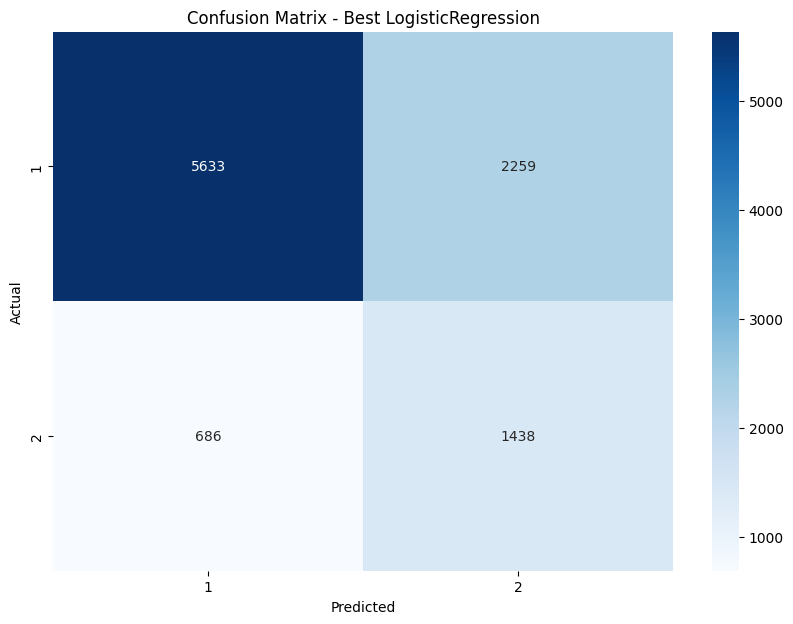

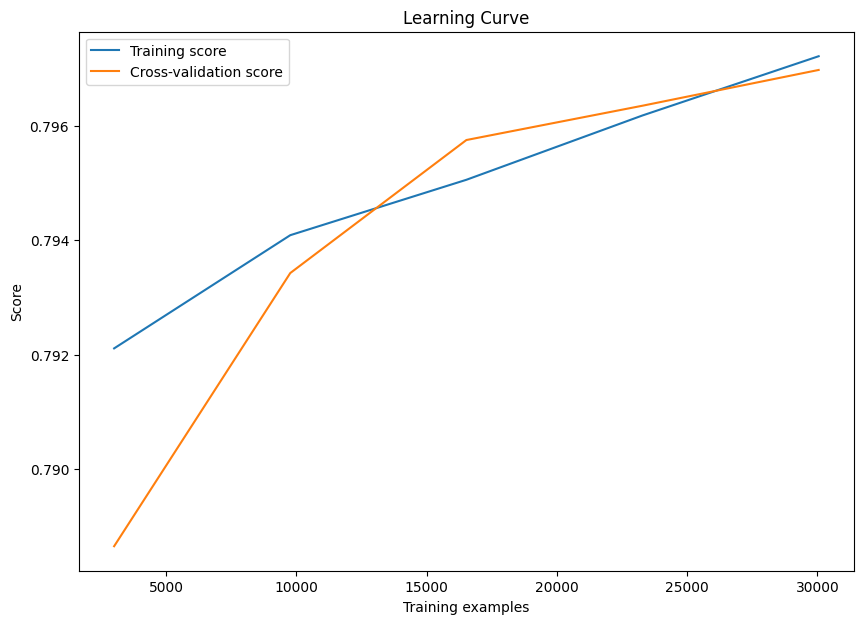

In [73]:
# Identificador del modelo
modelo = 'LogisticRegression'

# Inicializar GridSearchCV
grid_search = GridSearchCV(models[modelo]['model'], models[modelo]['params'], cv=4, scoring='accuracy')

# Crear el nombre a utilizar para guardar el modelo
fecha_hora_actual = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
nombre = f"{modelo}_{fecha_hora_actual}"

# Iniciar una nueva ejecución en MLflow con un nombre específico
with mlflow.start_run(run_name=nombre):
    # Ajustar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_resampled, y_resampled)

    # Obtener los mejores hiperparámetros
    best_params = grid_search.best_params_
    print("Mejores hiperparámetros:", best_params)

    # Registrar los mejores hiperparámetros en MLflow
    mlflow.log_params(best_params)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Realizar predicciones en el conjunto de prueba con el mejor modelo
    y_pred_best_model = best_model.predict(X_test)

    # Calcular y mostrar las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred_best_model)
    print(f"Accuracy del mejor modelo de {modelo}:", accuracy)

    # Registrar la métrica de precisión en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Matriz de confusión
    conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)
    print("Confusion Matrix del mejor modelo:\n", conf_matrix_best_model)

    # Reporte de clasificación
    classification_rep_best_model = classification_report(y_test, y_pred_best_model)
    print("Classification Report del mejor modelo:\n", classification_rep_best_model)

    # Guardar el mejor modelo en MLflow
    mlflow.sklearn.log_model(best_model, f"best_{nombre}")

    # Opcional: Guardar la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_best_model, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Best {modelo}")

    # Guardar la figura
    plt.savefig("confusion_matrix_best_model.png")

    # Registrar la figura en MLflow
    mlflow.log_artifact("confusion_matrix_best_model.png")

    # Eliminar el archivo localmente (opcional)
    os.remove("confusion_matrix_best_model.png")

    # Calcular las curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=4)

    # Graficar las curvas de aprendizaje
    plt.figure(figsize=(10, 7))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')

    # Guardar la figura de la curva de aprendizaje
    plt.savefig("learning_curve.png")

    # Registrar la figura de la curva de aprendizaje en MLflow
    mlflow.log_artifact("learning_curve.png")

    # Eliminar el archivo localmente (opcional)
    os.remove("learning_curve.png")

# Finalizar la ejecución (no es estrictamente necesario porque el contexto `with` ya lo hace)
mlflow.end_run()

## SVC

2024/06/02 22:54:33 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Mejores hiperparámetros: {'kernel': 'linear'}
Accuracy del mejor modelo de SVC: 0.665535143769968
Confusion Matrix del mejor modelo:
 [[5085 2807]
 [ 543 1581]]
Classification Report del mejor modelo:
               precision    recall  f1-score   support

           1       0.90      0.64      0.75      7892
           2       0.36      0.74      0.49      2124

    accuracy                           0.67     10016
   macro avg       0.63      0.69      0.62     10016
weighted avg       0.79      0.67      0.70     10016



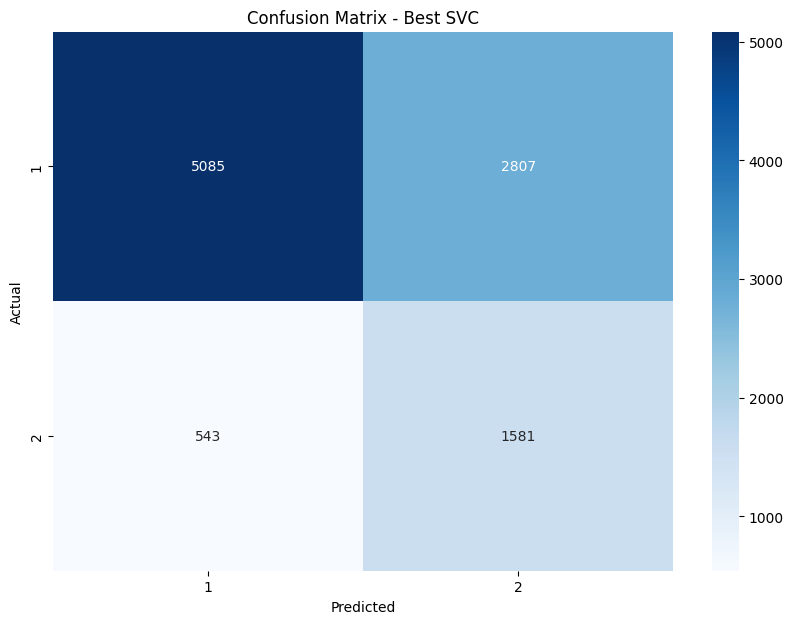

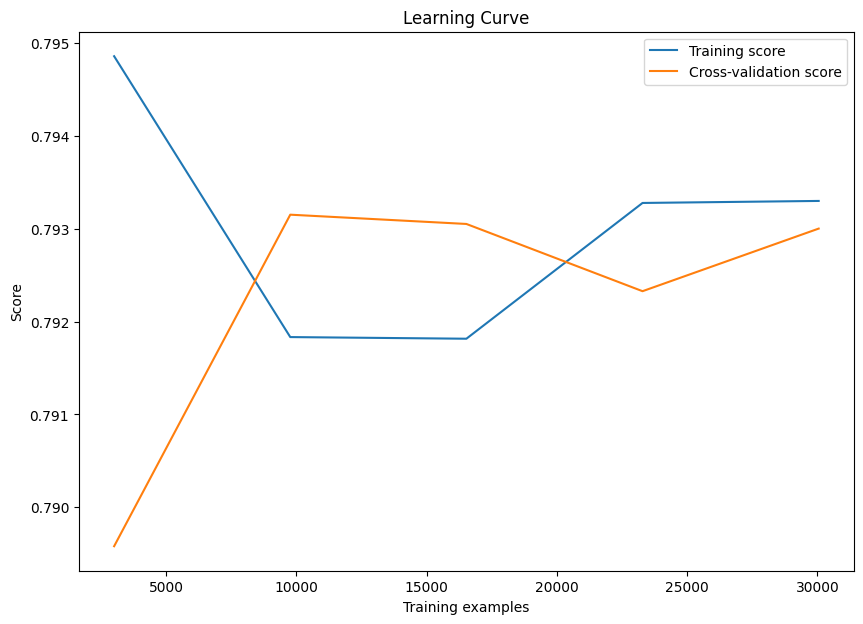

In [74]:
# Identificador del modelo
modelo = 'SVC'

# Inicializar GridSearchCV
grid_search = GridSearchCV(models[modelo]['model'], models[modelo]['params'], cv=4, scoring='accuracy')

# Crear el nombre a utilizar para guardar el modelo
fecha_hora_actual = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
nombre = f"{modelo}_{fecha_hora_actual}"

# Iniciar una nueva ejecución en MLflow con un nombre específico
with mlflow.start_run(run_name=nombre):
    # Ajustar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_resampled, y_resampled)

    # Obtener los mejores hiperparámetros
    best_params = grid_search.best_params_
    print("Mejores hiperparámetros:", best_params)

    # Registrar los mejores hiperparámetros en MLflow
    mlflow.log_params(best_params)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Realizar predicciones en el conjunto de prueba con el mejor modelo
    y_pred_best_model = best_model.predict(X_test)

    # Calcular y mostrar las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred_best_model)
    print(f"Accuracy del mejor modelo de {modelo}:", accuracy)

    # Registrar la métrica de precisión en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Matriz de confusión
    conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)
    print("Confusion Matrix del mejor modelo:\n", conf_matrix_best_model)

    # Reporte de clasificación
    classification_rep_best_model = classification_report(y_test, y_pred_best_model)
    print("Classification Report del mejor modelo:\n", classification_rep_best_model)

    # Guardar el mejor modelo en MLflow
    mlflow.sklearn.log_model(best_model, f"best_{nombre}")

    # Opcional: Guardar la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_best_model, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Best {modelo}")

    # Guardar la figura
    plt.savefig("confusion_matrix_best_model.png")

    # Registrar la figura en MLflow
    mlflow.log_artifact("confusion_matrix_best_model.png")

    # Eliminar el archivo localmente (opcional)
    os.remove("confusion_matrix_best_model.png")

    # Calcular las curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=4)

    # Graficar las curvas de aprendizaje
    plt.figure(figsize=(10, 7))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')

    # Guardar la figura de la curva de aprendizaje
    plt.savefig("learning_curve.png")

    # Registrar la figura de la curva de aprendizaje en MLflow
    mlflow.log_artifact("learning_curve.png")

    # Eliminar el archivo localmente (opcional)
    os.remove("learning_curve.png")

# Finalizar la ejecución (no es estrictamente necesario porque el contexto `with` ya lo hace)
mlflow.end_run()

## Random Forest Classifier

2024/06/02 23:14:32 INFO mlflow.sklearn.utils: Logging the 5 best runs, 11 runs will be omitted.


Mejores hiperparámetros: {'max_depth': 10, 'n_estimators': 200}
Accuracy del mejor modelo de RandomForestClassifier: 0.737020766773163
Confusion Matrix del mejor modelo:
 [[5929 1963]
 [ 671 1453]]
Classification Report del mejor modelo:
               precision    recall  f1-score   support

           1       0.90      0.75      0.82      7892
           2       0.43      0.68      0.52      2124

    accuracy                           0.74     10016
   macro avg       0.66      0.72      0.67     10016
weighted avg       0.80      0.74      0.76     10016



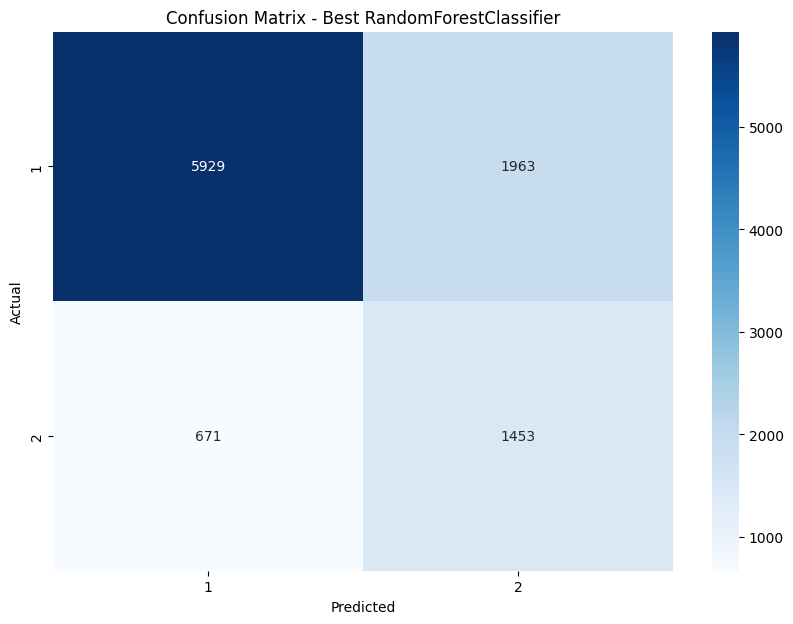

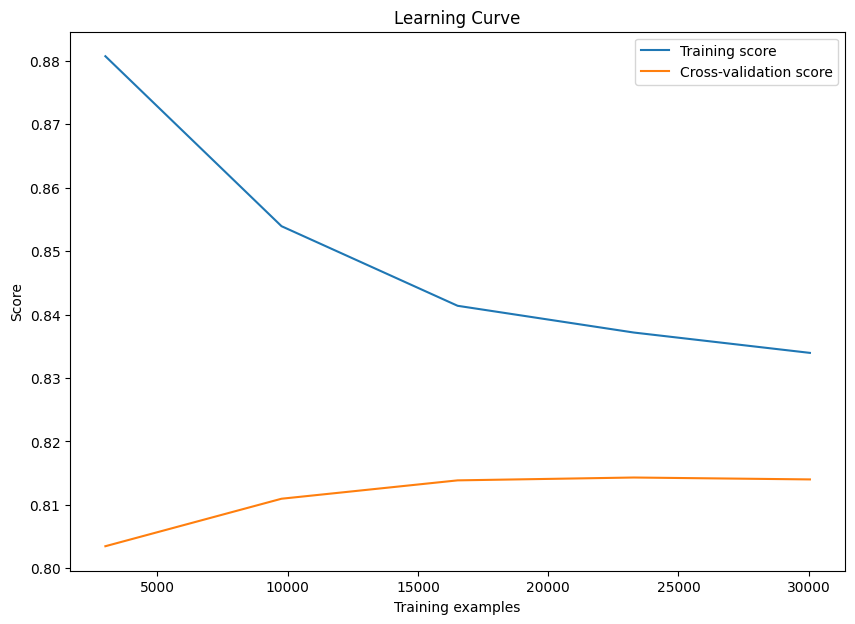

In [75]:
# Identificador del modelo
modelo = 'RandomForestClassifier'

# Inicializar GridSearchCV
grid_search = GridSearchCV(models[modelo]['model'], models[modelo]['params'], cv=4, scoring='accuracy')

# Crear el nombre a utilizar para guardar el modelo
fecha_hora_actual = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
nombre = f"{modelo}_{fecha_hora_actual}"

# Iniciar una nueva ejecución en MLflow con un nombre específico
with mlflow.start_run(run_name=nombre):
    # Ajustar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_resampled, y_resampled)

    # Obtener los mejores hiperparámetros
    best_params = grid_search.best_params_
    print("Mejores hiperparámetros:", best_params)

    # Registrar los mejores hiperparámetros en MLflow
    mlflow.log_params(best_params)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Realizar predicciones en el conjunto de prueba con el mejor modelo
    y_pred_best_model = best_model.predict(X_test)

    # Calcular y mostrar las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred_best_model)
    print(f"Accuracy del mejor modelo de {modelo}:", accuracy)

    # Registrar la métrica de precisión en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Matriz de confusión
    conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)
    print("Confusion Matrix del mejor modelo:\n", conf_matrix_best_model)

    # Reporte de clasificación
    classification_rep_best_model = classification_report(y_test, y_pred_best_model)
    print("Classification Report del mejor modelo:\n", classification_rep_best_model)

    # Guardar el mejor modelo en MLflow
    mlflow.sklearn.log_model(best_model, f"best_{nombre}")

    # Opcional: Guardar la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_best_model, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Best {modelo}")

    # Guardar la figura
    plt.savefig("confusion_matrix_best_model.png")

    # Registrar la figura en MLflow
    mlflow.log_artifact("confusion_matrix_best_model.png")

    # Eliminar el archivo localmente (opcional)
    os.remove("confusion_matrix_best_model.png")

    # Calcular las curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=4)

    # Graficar las curvas de aprendizaje
    plt.figure(figsize=(10, 7))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')

    # Guardar la figura de la curva de aprendizaje
    plt.savefig("learning_curve.png")

    # Registrar la figura de la curva de aprendizaje en MLflow
    mlflow.log_artifact("learning_curve.png")

    # Eliminar el archivo localmente (opcional)
    os.remove("learning_curve.png")

# Finalizar la ejecución (no es estrictamente necesario porque el contexto `with` ya lo hace)
mlflow.end_run()

2024/06/02 23:18:53 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Mejores hiperparámetros: {'kernel': 'linear'}
Accuracy del mejor modelo de SVC: 0.665535143769968
Confusion Matrix del mejor modelo:
 [[5085 2807]
 [ 543 1581]]
Classification Report del mejor modelo:
               precision    recall  f1-score   support

           1       0.90      0.64      0.75      7892
           2       0.36      0.74      0.49      2124

    accuracy                           0.67     10016
   macro avg       0.63      0.69      0.62     10016
weighted avg       0.79      0.67      0.70     10016



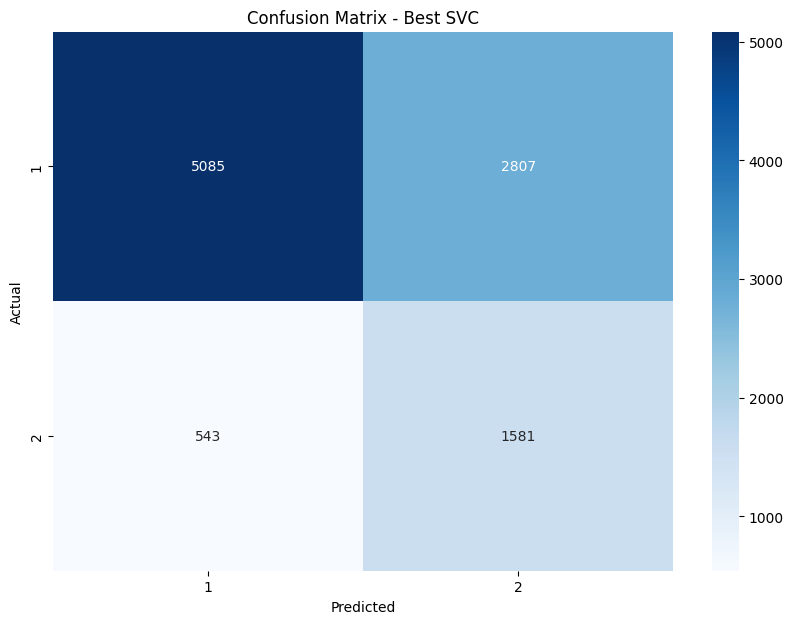

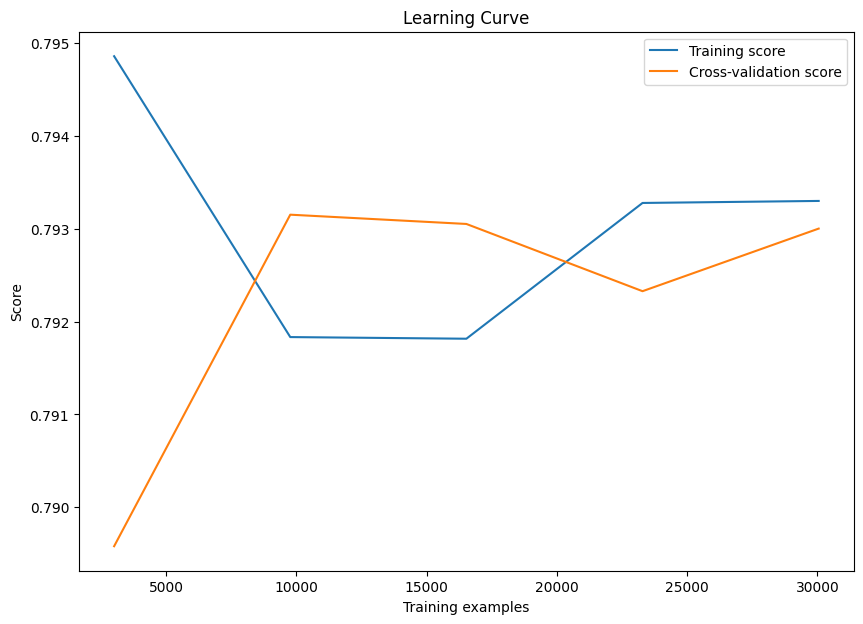

In [76]:
# Identificador del modelo
modelo = 'SVC'

# Inicializar GridSearchCV
grid_search = GridSearchCV(models[modelo]['model'], models[modelo]['params'], cv=4, scoring='accuracy')

# Crear el nombre a utilizar para guardar el modelo
fecha_hora_actual = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
nombre = f"{modelo}_{fecha_hora_actual}"

# Iniciar una nueva ejecución en MLflow con un nombre específico
with mlflow.start_run(run_name=nombre):
    # Ajustar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_resampled, y_resampled)

    # Obtener los mejores hiperparámetros
    best_params = grid_search.best_params_
    print("Mejores hiperparámetros:", best_params)

    # Registrar los mejores hiperparámetros en MLflow
    mlflow.log_params(best_params)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Realizar predicciones en el conjunto de prueba con el mejor modelo
    y_pred_best_model = best_model.predict(X_test)

    # Calcular y mostrar las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred_best_model)
    print(f"Accuracy del mejor modelo de {modelo}:", accuracy)

    # Registrar la métrica de precisión en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Matriz de confusión
    conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)
    print("Confusion Matrix del mejor modelo:\n", conf_matrix_best_model)

    # Reporte de clasificación
    classification_rep_best_model = classification_report(y_test, y_pred_best_model)
    print("Classification Report del mejor modelo:\n", classification_rep_best_model)

    # Guardar el mejor modelo en MLflow
    mlflow.sklearn.log_model(best_model, f"best_{nombre}")

    # Opcional: Guardar la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_best_model, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Best {modelo}")

    # Guardar la figura
    plt.savefig("confusion_matrix_best_model.png")

    # Registrar la figura en MLflow
    mlflow.log_artifact("confusion_matrix_best_model.png")

    # Eliminar el archivo localmente (opcional)
    os.remove("confusion_matrix_best_model.png")

    # Calcular las curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=4)

    # Graficar las curvas de aprendizaje
    plt.figure(figsize=(10, 7))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')

    # Guardar la figura de la curva de aprendizaje
    plt.savefig("learning_curve.png")

    # Registrar la figura de la curva de aprendizaje en MLflow
    mlflow.log_artifact("learning_curve.png")

    # Eliminar el archivo localmente (opcional)
    os.remove("learning_curve.png")

# Finalizar la ejecución (no es estrictamente necesario porque el contexto `with` ya lo hace)
mlflow.end_run()

## Gradient Boosting Classifier

2024/06/02 23:43:59 INFO mlflow.sklearn.utils: Logging the 5 best runs, 22 runs will be omitted.


Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Accuracy del mejor modelo de GradientBoostingClassifier: 0.7470047923322684
Confusion Matrix del mejor modelo:
 [[5947 1945]
 [ 589 1535]]
Classification Report del mejor modelo:
               precision    recall  f1-score   support

           1       0.91      0.75      0.82      7892
           2       0.44      0.72      0.55      2124

    accuracy                           0.75     10016
   macro avg       0.68      0.74      0.69     10016
weighted avg       0.81      0.75      0.77     10016



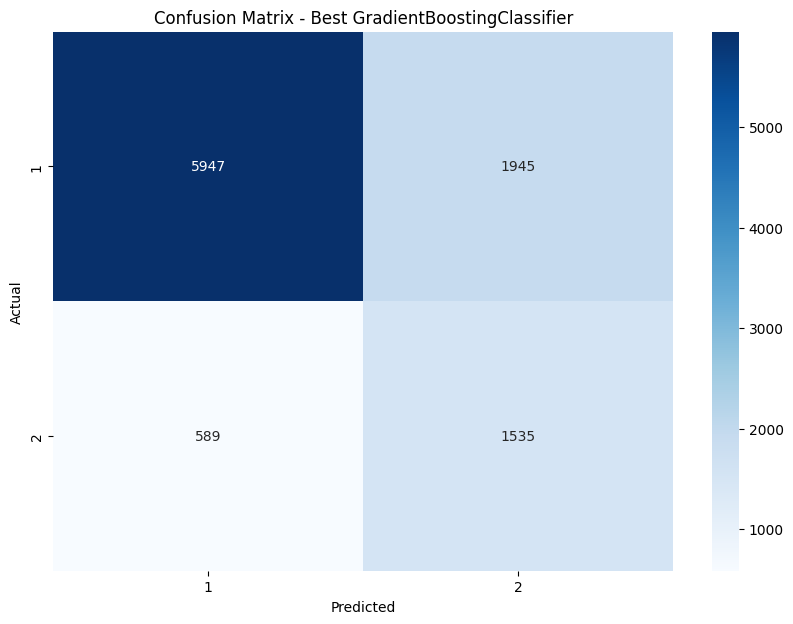

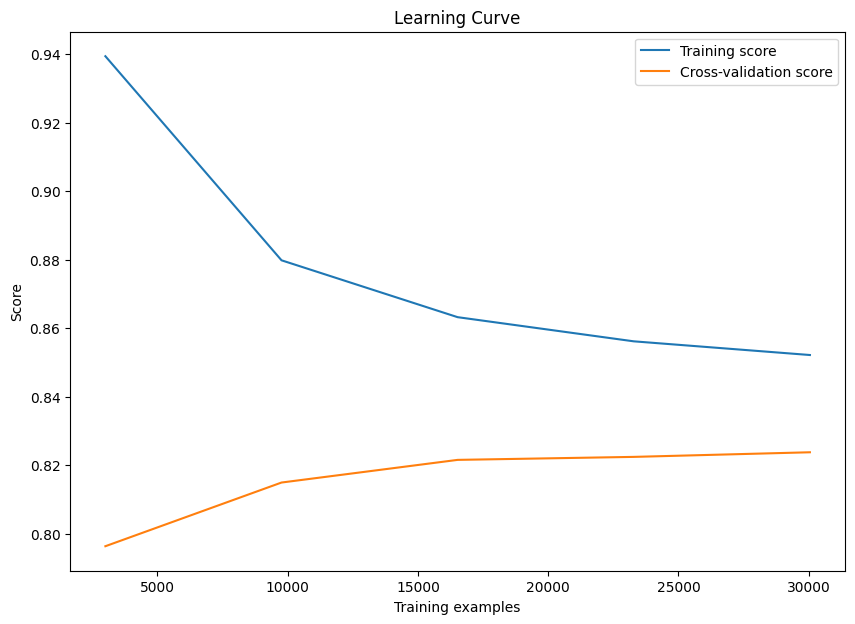

In [77]:
# Identificador del modelo
modelo = 'GradientBoostingClassifier'

# Inicializar GridSearchCV
grid_search = GridSearchCV(models[modelo]['model'], models[modelo]['params'], cv=4, scoring='accuracy')

# Crear el nombre a utilizar para guardar el modelo
fecha_hora_actual = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
nombre = f"{modelo}_{fecha_hora_actual}"

# Iniciar una nueva ejecución en MLflow con un nombre específico
with mlflow.start_run(run_name=nombre):
    # Ajustar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_resampled, y_resampled)

    # Obtener los mejores hiperparámetros
    best_params = grid_search.best_params_
    print("Mejores hiperparámetros:", best_params)

    # Registrar los mejores hiperparámetros en MLflow
    mlflow.log_params(best_params)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Realizar predicciones en el conjunto de prueba con el mejor modelo
    y_pred_best_model = best_model.predict(X_test)

    # Calcular y mostrar las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred_best_model)
    print(f"Accuracy del mejor modelo de {modelo}:", accuracy)

    # Registrar la métrica de precisión en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Matriz de confusión
    conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)
    print("Confusion Matrix del mejor modelo:\n", conf_matrix_best_model)

    # Reporte de clasificación
    classification_rep_best_model = classification_report(y_test, y_pred_best_model)
    print("Classification Report del mejor modelo:\n", classification_rep_best_model)

    # Guardar el mejor modelo en MLflow
    mlflow.sklearn.log_model(best_model, f"best_{nombre}")

    # Opcional: Guardar la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_best_model, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Best {modelo}")

    # Guardar la figura
    plt.savefig("confusion_matrix_best_model.png")

    # Registrar la figura en MLflow
    mlflow.log_artifact("confusion_matrix_best_model.png")

    # Eliminar el archivo localmente (opcional)
    os.remove("confusion_matrix_best_model.png")

    # Calcular las curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=4)

    # Graficar las curvas de aprendizaje
    plt.figure(figsize=(10, 7))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')

    # Guardar la figura de la curva de aprendizaje
    plt.savefig("learning_curve.png")

    # Registrar la figura de la curva de aprendizaje en MLflow
    mlflow.log_artifact("learning_curve.png")

    # Eliminar el archivo localmente (opcional)
    os.remove("learning_curve.png")

# Finalizar la ejecución (no es estrictamente necesario porque el contexto `with` ya lo hace)
mlflow.end_run()

## KNeighbors Classifier

2024/06/02 23:46:22 INFO mlflow.sklearn.utils: Logging the 5 best runs, no runs will be omitted.


Mejores hiperparámetros: {'n_neighbors': 9}
Accuracy del mejor modelo de KNeighborsClassifier: 0.6972843450479234
Confusion Matrix del mejor modelo:
 [[5504 2388]
 [ 644 1480]]
Classification Report del mejor modelo:
               precision    recall  f1-score   support

           1       0.90      0.70      0.78      7892
           2       0.38      0.70      0.49      2124

    accuracy                           0.70     10016
   macro avg       0.64      0.70      0.64     10016
weighted avg       0.79      0.70      0.72     10016



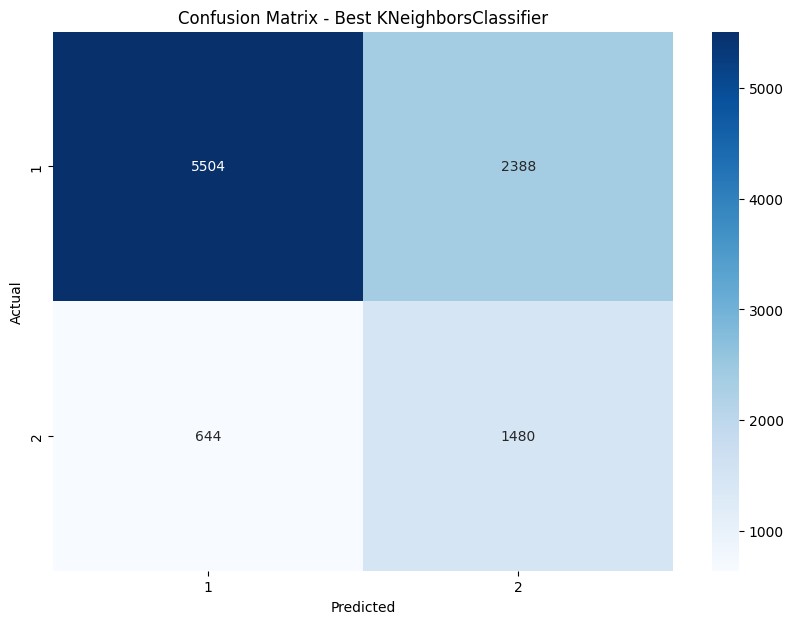

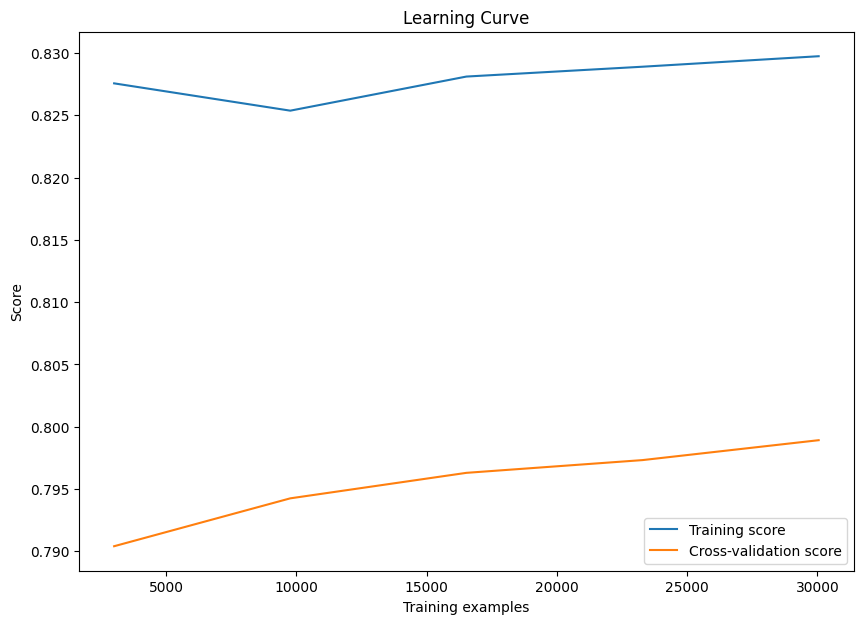

In [78]:
# Identificador del modelo
modelo = 'KNeighborsClassifier'

# Inicializar GridSearchCV
grid_search = GridSearchCV(models[modelo]['model'], models[modelo]['params'], cv=4, scoring='accuracy')

# Crear el nombre a utilizar para guardar el modelo
fecha_hora_actual = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
nombre = f"{modelo}_{fecha_hora_actual}"

# Iniciar una nueva ejecución en MLflow con un nombre específico
with mlflow.start_run(run_name=nombre):
    # Ajustar GridSearchCV en los datos de entrenamiento
    grid_search.fit(X_resampled, y_resampled)

    # Obtener los mejores hiperparámetros
    best_params = grid_search.best_params_
    print("Mejores hiperparámetros:", best_params)

    # Registrar los mejores hiperparámetros en MLflow
    mlflow.log_params(best_params)

    # Obtener el mejor modelo
    best_model = grid_search.best_estimator_

    # Realizar predicciones en el conjunto de prueba con el mejor modelo
    y_pred_best_model = best_model.predict(X_test)

    # Calcular y mostrar las métricas de evaluación
    accuracy = accuracy_score(y_test, y_pred_best_model)
    print(f"Accuracy del mejor modelo de {modelo}:", accuracy)

    # Registrar la métrica de precisión en MLflow
    mlflow.log_metric("accuracy", accuracy)

    # Matriz de confusión
    conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)
    print("Confusion Matrix del mejor modelo:\n", conf_matrix_best_model)

    # Reporte de clasificación
    classification_rep_best_model = classification_report(y_test, y_pred_best_model)
    print("Classification Report del mejor modelo:\n", classification_rep_best_model)

    # Guardar el mejor modelo en MLflow
    mlflow.sklearn.log_model(best_model, f"best_{nombre}")

    # Opcional: Guardar la matriz de confusión como un artefacto
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix_best_model, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Best {modelo}")

    # Guardar la figura
    plt.savefig("confusion_matrix_best_model.png")

    # Registrar la figura en MLflow
    mlflow.log_artifact("confusion_matrix_best_model.png")

    # Eliminar el archivo localmente (opcional)
    os.remove("confusion_matrix_best_model.png")

    # Calcular las curvas de aprendizaje
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=4)

    # Graficar las curvas de aprendizaje
    plt.figure(figsize=(10, 7))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')

    # Guardar la figura de la curva de aprendizaje
    plt.savefig("learning_curve.png")

    # Registrar la figura de la curva de aprendizaje en MLflow
    mlflow.log_artifact("learning_curve.png")

    # Eliminar el archivo localmente (opcional)
    os.remove("learning_curve.png")

# Finalizar la ejecución (no es estrictamente necesario porque el contexto `with` ya lo hace)
mlflow.end_run()

## Red neuronal de clasificación binaria

In [103]:
# pip install tensorflow


In [102]:
# import kerastuner as kt
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam
# from sklearn.model_selection import train_test_split
# from sklearn.datasets import make_classification
# import mlflow
# import mlflow.keras
# import datetime

# # Generar datos de ejemplo
# X_train1, X_val, y_train1, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# # Definir el input_shape
# input_shape = (X_train1.shape[1],)

# def model_builder(hp):
#     model = Sequential()
    
#     model.add(Dense(units=hp.Int('input_units', min_value=32, max_value=512, step=32),
#                     activation='relu',
#                     input_shape=input_shape))
    
#     for i in range(hp.Int('num_layers', 1, 5)):
#         model.add(Dense(units=hp.Int(f'layer_{i}_units', min_value=32, max_value=256, step=32),
#                         activation='relu'))
    
#     model.add(Dense(units=1, activation='sigmoid'))
    
#     hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#     model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])
    
#     return model

# # Crear el nombre a utilizar para guardar el modelo
# fecha_hora_actual = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# nombre = f"modelo_{fecha_hora_actual}"

# # Iniciar una ejecución de MLflow
# with mlflow.start_run(run_name=nombre):
#     tuner = kt.Hyperband(model_builder,
#                          objective='val_accuracy',
#                          max_epochs=10,
#                          factor=3,
#                          directory='keras_tuner_dir',
#                          project_name='neural_network_tuning')

#     tuner.search(X_train1, y_train1,
#                  epochs=5,
#                  validation_split=0.2,
#                  callbacks=[mlflow.keras.MlflowCallback()],
#                  verbose=1)
    
#     # Obtener el mejor modelo
#     best_model = tuner.get_best_models(num_models=1)[0]
    
#     # Evaluar el mejor modelo
#     loss, accuracy = best_model.evaluate(X_val, y_val)
#     print(f"Precisión del mejor modelo: {accuracy}")
    
#     # Registrar el modelo y la métrica de precisión en MLflow
#     mlflow.log_metric("accuracy", accuracy)
#     mlflow.keras.log_model(best_model, "best_model")


In [104]:
# # Crear el nombre a utilizar para guardar el modelo
# fecha_hora_actual = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
# nombre = f"{modelo}_{fecha_hora_actual}"

# with mlflow.start_run(run_name=nombre):
#     tuner.search(X_resampled, y_resampled,
#                  epochs=5,
#                  validation_split=0.2)
    
#     # Definir el callback EarlyStopping
#     early_stopping = EarlyStopping(
#     monitor='val_loss',  # Métrica que queremos monitorear
#     patience=10,         # Número de épocas sin mejora después de las cuales se detiene el entrenamiento
#     restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
# )

#     # Definir el callback ModelCheckpoint para guardar el mejor modelo durante el entrenamiento
#     model_checkpoint = ModelCheckpoint(
#         filepath='best_model.h5',  # Ruta donde se guardará el mejor modelo
#         monitor='val_loss',        # Métrica que queremos monitorear
#         save_best_only=True        # Guardar solo el mejor modelo
#     )

#     # Entrenar el mejor modelo con más épocas y los callbacks definidos
#     best_model.fit(
#         X_resampled, y_resampled,
#         epochs=100,  # Número total de épocas
#         validation_split=0.2,  # División de validación del 20%
#         callbacks=[early_stopping, model_checkpoint, mlflow.keras.KerasCallback()]  # Lista de callbacks
#     )
#     best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
#     best_model = tuner.hypermodel.build(best_hps)

#     best_model.fit(X_resampled, y_resampled,
#                 epochs=100,
#                 validation_split=0.2,
#                 stratify=y_resampled,
#                 callbacks=[early_stopping, model_checkpoint, mlflow.keras.KerasCallback()])

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

best_model.fit(X_resampled, y_resampled,
               epochs=100,
               validation_split=0.2,
               stratify=y_resampled,
               callbacks=[mlflow.keras.KerasCallback()])

In [ ]:
mlflow.sklearn.log_model(best_model, f"best_{nombre}")

y_pred_best_model = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_best_model)
mlflow.log_metric("accuracy", accuracy)

conf_matrix_best_model = confusion_matrix(y_test, y_pred_best_model)
mlflow.log_artifact("confusion_matrix_best_model.png")

classification_rep_best_model = classification_report(y_test, y_pred_best_model)
mlflow.log_param("classification_report", classification_rep_best_model)

train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=4)
mlflow.log_artifact("learning_curve.png")


In [ ]:
mlflow.end_run()

## Selección del modelo

En el contexto médico en el que estamos desarrollando un modelo para clasificación de tipo de paciente, es fundamental no solo evaluar el rendimiento global del modelo, sino también entender cómo aprende a lo largo del tiempo. Para la selección del modelo, nos interesan particularmente tres aspectos clave:

Curvas de aprendizaje: Estas visualizaciones nos permiten observar cómo mejora el rendimiento del modelo a medida que se incrementa la cantidad de datos de entrenamiento. Analizar las curvas de aprendizaje nos ayuda a identificar si el modelo está sufriendo de sobreajuste (overfitting) o subajuste (underfitting), y si más datos de entrenamiento pueden mejorar su rendimiento.

Medidas de desempeño: Las métricas de evaluación, como la precisión, el valor F1, la especificidad y la sensibilidad, son cruciales para evaluar la efectividad del modelo. En el caso específico de la detección de dengue, nos interesa especialmente obtener un alto valor de sensibilidad, ya que es importante minimizar los falsos negativos (es decir, los casos de dengue que el modelo no detecta).

Matrices de confusión y reportes de clasificación: Estas herramientas nos proporcionan una visión detallada de los verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos. Nos permiten analizar en profundidad los errores del modelo y ajustar nuestras estrategias para mejorar su rendimiento.

Al seleccionar el modelo adecuado para la detección de dengue, nos enfocamos en entender cómo aprende el modelo mediante las curvas de aprendizaje, evaluamos su rendimiento con diversas métricas de desempeño y prestamos especial atención a la sensibilidad para asegurar que se identifique correctamente la mayor cantidad posible de casos de dengue.

Por estas razones, hemos seleccionado el mejor modelo construido mediante el clasificador Gradient Boosting (Gradient Boosting Classifier).